<a href="https://colab.research.google.com/github/MatheoCruz/BLR_perovskite/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from functools import partial
from scipy.stats import norm
from sklearn.model_selection import KFold
from scipy import stats
import seaborn as sns
import pickle

In [ ]:
#Import data base
data = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/data_training_copy.csv")
KDE_X = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/KDE_X.csv")
KDE_Y = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/KDE_Y.csv")
kde_X = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/kde_X_copy.csv")
kde_Y = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/kde_Y_copy.csv")

In [ ]:
#DataFrame
data = pd.DataFrame(data)
KDE_X = pd.DataFrame(KDE_X)
KDE_Y = pd.DataFrame(KDE_Y)
kde_X = pd.DataFrame(kde_X)
kde_Y = pd.DataFrame(kde_Y)

Funciones creadas en base a las necesidades de la construccion y posterior inferencia del modelo de prediccion

In [ ]:
def Transformaciones(datos, condicion):
  if condicion == 'Thickness' or condicion == 'Jsc' or condicion == "Grain_size":
    transformacion = {
        'A': np.exp,
        'B': np.exp,
        'X': np.exp,
        'Band_gap': np.exp,
        'DeltaH': np.exp,
        'DeltaL': np.exp,
        'Grain_size': np.sqrt,
        'Thickness': np.log,
        'PCE': None,
        'Voc': np.exp,
        'Jsc': None,
        'FF': np.exp,
    }
    retorno = {}
    for column_name in datos.columns:
      column = datos[column_name]
      column_transformada = column if transformacion[column_name] is None else column.apply(transformacion[column_name])
      retorno[column_name] = column_transformada
    retorno = pd.DataFrame(retorno)
    print("se hizo transformacion")
  else:
    retorno = datos
  return retorno
def build_linear_model(X,y,data,entradas,kde_x,kde_y):
    with pm.Model() as modelo:
        x_shared = pm.Data("x_shared", X, mutable = True)
        alpha = pm.Interpolated(data, np.asarray(kde_x[data]), np.asarray(kde_y[data]))
        #betas = pm.Normal('betas', mu = 0, sigma = 10, shape = x_shared.shape[1])
        betas = []
        for entrada in entradas:
         betas.append(prior(entrada, 0, 10))
        # Varianza del error
        sigma = pm.HalfNormal('sigma',sigma = 1)

        # Media
        y_est = pm.Deterministic('y_est', alpha + pm.math.dot(x_shared,betas))

        # Likelihood
        likelihood = pm.Normal('y_obs',mu = y_est, sigma=sigma, observed = y)

        # Regularización L2
        reg = pm.math.sum(pm.math.sqr(betas)) + pm.math.sqr(alpha)
        ridge = pm.Potential('ridge', -0.5*reg)
    return modelo

In [ ]:
#creamos los kde para la construccion de los priori
kde_x = {'A':KDE_X['A'], 'B':KDE_X['B'], 'X':KDE_X['X'], 'Band_gap':KDE_X['Bandgap'],
         'DeltaH':kde_X['DeltaH'], 'DeltaL':kde_X['DeltaL'], 'Grain_size':kde_X['Grain_size'],
         'Thickness':KDE_X['Thickness'], 'PCE':KDE_X['PCE'], 'Voc':KDE_X['Voc'], 'Jsc':KDE_X['Jsc'], 'FF':KDE_X['FF']}
kde_y = {'A':KDE_Y['A'], 'B':KDE_Y['B'], 'X':KDE_Y['X'], 'Band_gap':KDE_Y['Bandgap'],
         'DeltaH':kde_Y['DeltaH'], 'DeltaL':kde_Y['DeltaL'], 'Grain_size':kde_Y['Grain_size'],
         'Thickness':KDE_Y['Thickness'], 'PCE':KDE_Y['PCE'], 'Voc':KDE_Y['Voc'], 'Jsc':KDE_Y['Jsc'], 'FF':KDE_Y['FF']}
kde_x = pd.DataFrame(kde_x)
kde_y = pd.DataFrame(kde_y)

<Axes: >

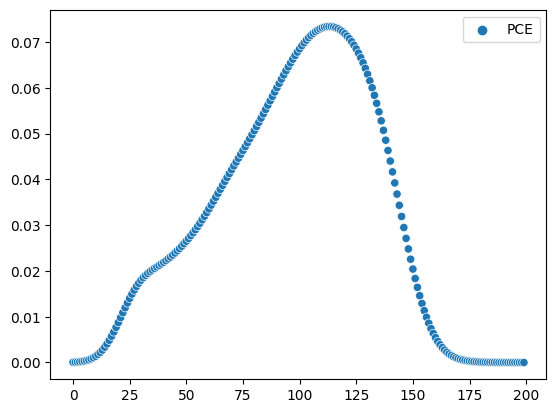

In [ ]:
sns.scatterplot((KDE_X['PCE'], KDE_Y['PCE']))

Construccion de los modelos para cada variable en cada K-fold

In [ ]:
k=5
kf = KFold(n_splits = k)
modelos = {}
data_train = {}
data_test = {}
trazados_data = {}
for datos in data[data.columns[3:]]:
  output = data[datos]
  inputs = data.drop(datos, axis = 1)
  inputs = Transformaciones(inputs, datos)
  modelos_fold = {}
  data_train_fold = {}
  data_test_fold = {}
  trazados_fold = {}
  j=1
  print(datos)
  for train_index, test_index in kf.split(inputs):
    print('Fold #',j,'para el parametro', datos)
    x_train, x_test = np.asarray(inputs)[train_index], np.asarray(inputs)[test_index]
    y_train, y_test = np.asarray(output)[train_index], np.asarray(output)[test_index]
    print(x_train.shape)
    x_mean = np.mean(x_train, axis = 0)
    x_std = np.std(x_train, axis = 0)
    y_mean = np.mean(y_train)
    y_std = np.std(y_train)
    X_train = (x_train-x_mean)/(x_std)
    Y_train = (y_train-y_mean)/(y_std)
    X_train[:,1] = x_train[:,1]
    X_test = (x_test-x_mean)/(x_std)
    X_test[:,1] = x_test[:,1]
    Y_test = (y_test-y_mean)/(y_std)
    model = build_linear_model(X_train,Y_train,datos,inputs,kde_x,kde_y)
    modelos_fold[f'modelo_fold_{j}'] = model
    #trazados_fold[f'trace_fold{j}'] = trace
    data_train_fold[f'train_fold_{j}'] = {'x_train':X_train, 'y_train':Y_train, 'y_mean':y_mean, 'y_std':y_std, 'x_mean':x_mean, 'x_std':x_std}
    data_test_fold[f'test_fold_{j}'] = {'x_test':X_test, 'y_test':y_test}
    j = j+1
  modelos[f'modelo_{datos}'] = modelos_fold
  #trazados_data[f'trace_{datos}'] = trazados_fold
  data_train[f'data_train_{datos}'] = data_train_fold
  data_test[f'data_test_{datos}'] = data_test_fold

Band_gap
Fold # 1 para el parametro Band_gap
(50, 11)
Fold # 2 para el parametro Band_gap
(50, 11)
Fold # 3 para el parametro Band_gap
(50, 11)
Fold # 4 para el parametro Band_gap
(51, 11)
Fold # 5 para el parametro Band_gap
(51, 11)
DeltaH
Fold # 1 para el parametro DeltaH
(50, 11)


<ipython-input-8-242e2527ade5>:26: RuntimeWarning: invalid value encountered in true_divide
  X_train = (x_train-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: divide by zero encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: invalid value encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)


Fold # 2 para el parametro DeltaH
(50, 11)
Fold # 3 para el parametro DeltaH
(50, 11)
Fold # 4 para el parametro DeltaH
(51, 11)
Fold # 5 para el parametro DeltaH
(51, 11)
DeltaL
Fold # 1 para el parametro DeltaL
(50, 11)


<ipython-input-8-242e2527ade5>:26: RuntimeWarning: invalid value encountered in true_divide
  X_train = (x_train-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: divide by zero encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: invalid value encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)


Fold # 2 para el parametro DeltaL
(50, 11)
Fold # 3 para el parametro DeltaL
(50, 11)
Fold # 4 para el parametro DeltaL
(51, 11)
Fold # 5 para el parametro DeltaL
(51, 11)


<ipython-input-8-242e2527ade5>:26: RuntimeWarning: invalid value encountered in true_divide
  X_train = (x_train-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: divide by zero encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: invalid value encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)


se hizo transformacion
Grain_size
Fold # 1 para el parametro Grain_size
(50, 11)
Fold # 2 para el parametro Grain_size
(50, 11)
Fold # 3 para el parametro Grain_size
(50, 11)
Fold # 4 para el parametro Grain_size
(51, 11)
Fold # 5 para el parametro Grain_size
(51, 11)
se hizo transformacion
Thickness
Fold # 1 para el parametro Thickness
(50, 11)
Fold # 2 para el parametro Thickness
(50, 11)
Fold # 3 para el parametro Thickness
(50, 11)
Fold # 4 para el parametro Thickness
(51, 11)
Fold # 5 para el parametro Thickness
(51, 11)
PCE
Fold # 1 para el parametro PCE
(50, 11)
Fold # 2 para el parametro PCE
(50, 11)
Fold # 3 para el parametro PCE
(50, 11)
Fold # 4 para el parametro PCE
(51, 11)
Fold # 5 para el parametro PCE
(51, 11)
Voc
Fold # 1 para el parametro Voc
(50, 11)


<ipython-input-8-242e2527ade5>:26: RuntimeWarning: invalid value encountered in true_divide
  X_train = (x_train-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: divide by zero encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: invalid value encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)


Fold # 2 para el parametro Voc
(50, 11)
Fold # 3 para el parametro Voc
(50, 11)
Fold # 4 para el parametro Voc
(51, 11)
Fold # 5 para el parametro Voc
(51, 11)
se hizo transformacion
Jsc
Fold # 1 para el parametro Jsc
(50, 11)
Fold # 2 para el parametro Jsc
(50, 11)


<ipython-input-8-242e2527ade5>:26: RuntimeWarning: invalid value encountered in true_divide
  X_train = (x_train-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: divide by zero encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: invalid value encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)


Fold # 3 para el parametro Jsc
(50, 11)
Fold # 4 para el parametro Jsc
(51, 11)
Fold # 5 para el parametro Jsc
(51, 11)
FF
Fold # 1 para el parametro FF
(50, 11)
Fold # 2 para el parametro FF
(50, 11)
Fold # 3 para el parametro FF
(50, 11)
Fold # 4 para el parametro FF
(51, 11)
Fold # 5 para el parametro FF
(51, 11)


<ipython-input-8-242e2527ade5>:26: RuntimeWarning: invalid value encountered in true_divide
  X_train = (x_train-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: divide by zero encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)
<ipython-input-8-242e2527ade5>:29: RuntimeWarning: invalid value encountered in true_divide
  X_test = (x_test-x_mean)/(x_std)


Archivo que carga los datos de entrenamiento y testeo basado en cada fold

In [ ]:
ruta_drive = '/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/'

In [ ]:
with open(ruta_drive + 'data_train.pkl', 'wb') as f:
    pickle.dump(data_train, f)

In [ ]:
with open(ruta_drive + 'data_test.pkl', 'wb') as f:
    pickle.dump(data_test, f)

Fase de inferencia o entrenamiento del modelo

In [ ]:
draws = 1000
tune = 500
chains = 5
trazados_data = {}
for datos in data[data.columns[3:]]:
  print(datos)
  trazados_fold = {}
  for i in range(1,6):
    with modelos[f'modelo_{datos}'][f'modelo_fold_{i}']:
      trace = pm.sample(draws = draws, tune = tune, chains = chains, cores = 4)
    trazados_fold[f'trace_fold{i}'] = trace
  trazados_data[f'trace_{datos}'] = trazados_fold

Band_gap


ERROR:pymc:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


ERROR:pymc:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


DeltaH


DeltaL


Grain_size


Thickness


PCE


ERROR:pymc:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


ERROR:pymc:There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


Voc


Jsc


ERROR:pymc:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


ERROR:pymc:There were 29 divergences after tuning. Increase `target_accept` or reparameterize.


FF


ERROR:pymc:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Archivo cargado con la informacion de los trazos generados por le modelo para la construccion de los modelos de inferencia

In [ ]:
ruta_drive = '/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/'

In [ ]:
with open(ruta_drive + 'trazados.pkl', 'wb') as f:
    pickle.dump(trazados_data, f)

In [ ]:
with open(ruta_drive + 'trazados.pkl', 'rb') as f:
    trazados_cargados = pickle.load(f)